In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import zeta
from scipy.optimize import linprog

import seaborn as sns

sns.set_theme()

In [2]:
def create_K_alpha(alpha):
    """Returns the kernel function $K_alpha(m,n)$"""
    def K(x, y):
        x+=1
        y+=1
        return (1 / np.sqrt(x*y)) * ((x*y)**alpha / np.maximum(x, y)**(2*alpha))
    return K

def create_A(alpha, N):
    """Creates the matrix A with entries $A_{m,n} = K_alpha(m,n)$"""
    K_alpha = create_K_alpha(alpha)

    A = np.fromfunction(K_alpha, (N, N))
    return A

In [281]:
def lp(N, alpha, goal_fn = lambda alph: 2/alph):
    """Solves linear program specified by Schur test for the kernel $K_alpha$ truncated to N terms."""
    goal = goal_fn(alpha)

    ms = np.arange(1, N+1)
    truncated_zeta = zeta(alpha + 1) - sum(1/ms**(alpha+1))
    ubs = -ms**(alpha - 1/2) * truncated_zeta

    B = create_A(alpha, N) - np.diag(goal * np.ones(N))

    c = ms**(alpha - 1/2) 
    res = linprog(c, A_ub=B, b_ub=ubs)
    return c, res, ms


def requirement(N, alpha, brevig_bound=False):
    """Gives upper bound on c @ x where x is the solution to the linear program. If it is not 
     an upper bound, then the full linear program is unfeasible. """
    if brevig_bound:
        term1 = - alpha/6 * (N+1)**(alpha - 2) + (3-alpha)*(5-alpha)*(6-alpha)*(8+alpha)/(720*alpha)
        term2 = sum(n**(alpha - 1) for n in range(1, N+1))
        return term1 + term2
    else:
        ssum = zeta(alpha + 1) - sum(1/n**(alpha+1) for n in range(1, N+1))
        return (N+1)**alpha * (2/alpha - (N+1)**(alpha) * ssum)

# # print(res.x)

# print(c @ res.x)
# print(requirement(N, alpha))

c, res, ms = lp(2, 1.5)

# print(c)
requirement(1, 1)
 

1.4202637326070944

In [325]:
def compare(N, alphas, brevig_bound=False):
    """returns list of c @ x and upper bounds for each alpha. If c @ x > upper bound, then the
    full linear program is unfeasible."""
    reqs = []
    found = []
    for alpha in alphas:
        c, res, ms = lp(N, alpha)
        reqs.append(requirement(N, alpha, brevig_bound))
        found.append(c @ res.x)

    return reqs, found

def find_intersection(N, alphas, brevig_bound=False):
    """Finds point of intersection for requirement, c@x. The ntersection is the point where 
    the linear program starts to fail in showing C_alpha = 2/alpha"""
    reqs, found = compare(N, alphas, brevig_bound)

    for i in range(len(reqs)):
        if found[i] > reqs[i]:
            if i == 0:
                return None
            else:
                return alphas[i-1]
    return None

Example showcasing what the intersection is

In [358]:
N = 10
alphas = np.linspace(1.5, 1.55, 20)
reqs, found = compare(N, alphas)
brevig_reqs, _ = compare(N, alphas, True)

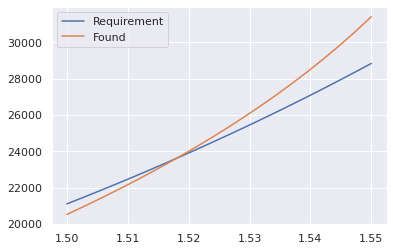

Difference between zeta requirement, Brevig requirement: 6.75555675115902e-05


In [294]:
plt.plot(alphas, reqs, label="Requirement")
# plt.plot(alphas, brevig_reqs, label="Brevig Requirement")
plt.plot(alphas, found, label="Found")

plt.legend()
plt.show()
print("Difference between zeta requirement, Brevig requirement:",
      min([abs(x -y) for x, y in zip(reqs, brevig_reqs)]))

Search for intersection for different N-values

In [298]:
N_list = [1, 2, 3, 4, 5, 10, 20, 50, 100, 200, 500, 1000]
alpha_intersect_list = []
for N in N_list:
    alphas = np.linspace(1.45, 1.6, 1001)
    alpha_intersect = find_intersection(N, alphas)
    alpha_intersect_list.append(alpha_intersect)
    print(". ", end="")
print()

. . . . . . . . . . . . 


In [307]:
dalpha = alphas[1] - alphas[0]
ub_alpha_intersect_list = [alpha + dalpha for alpha in alpha_intersect_list]
print(alpha_intersect_list)

[1.5067, 1.51255, 1.5148, 1.516, 1.51645, 1.5175, 1.5178, 1.51795, 1.51795, 1.51795, 1.51795, 1.51795]


In [313]:
# print lower and upper bounds in latex table format
print("\\begin{tabular}{c c}")
print("N & $\\alpha$-interval\\\\")
print("\\hline")
for N, alpha, ub_alpha in zip(N_list, alpha_intersect_list, ub_alpha_intersect_list):
    print(f"{N} & $[{alpha:.5f}, {ub_alpha:.5f}]$ \\\\")
print("\\end{tabular}")

\begin{tabular}{c c}
N & $\alpha$-interval\\
\hline
1 & $[1.50670, 1.50685]$ \\
2 & $[1.51255, 1.51270]$ \\
3 & $[1.51480, 1.51495]$ \\
4 & $[1.51600, 1.51615]$ \\
5 & $[1.51645, 1.51660]$ \\
10 & $[1.51750, 1.51765]$ \\
20 & $[1.51780, 1.51795]$ \\
50 & $[1.51795, 1.51810]$ \\
100 & $[1.51795, 1.51810]$ \\
200 & $[1.51795, 1.51810]$ \\
500 & $[1.51795, 1.51810]$ \\
1000 & $[1.51795, 1.51810]$ \\
\end{tabular}


Finegrained search for intersection

In [326]:
alpha_lb = alpha_intersect_list[-1]
alpha_ub = ub_alpha_intersect_list[-1]
alphas = np.linspace(alpha_lb, alpha_ub, 1001)
print(min(alphas), max(alphas))

N_list = [1, 2, 3, 4, 5, 10, 20, 50, 100, 200, 500, 1000]
alpha_int_list_2 = []
for N in N_list:
    alpha_int = find_intersection(N, alphas)
    alpha_int_list_2.append(alpha_int)
    print(". ", end="")
print()

1.51795 1.5181
. . . . . . . . . . . . 


In [329]:
dalpha = alphas[1] - alphas[0]
ub_alpha_int_list_2 = []
for alpha in alpha_int_list_2:
    if alpha is not None:
        ub_alpha_int_list_2.append(alpha + dalpha)
    else:
        ub_alpha_int_list_2.append(None)
print(alpha_int_list_2)
print(ub_alpha_int_list_2)
print(alphas)

[None, None, None, None, None, None, None, 1.5179707, 1.51798525, 1.517989, 1.5179900499999999, 1.5179901999999998]
[None, None, None, None, None, None, None, 1.51797085, 1.5179854, 1.51798915, 1.5179901999999998, 1.5179903499999998]
[1.51795    1.51795015 1.5179503  ... 1.5180997  1.51809985 1.5181    ]


In [343]:
# print values that are not none in latex table format
print("\\begin{tabular}{c c}")
print("N & $\\alpha$-interval\\\\")
print("\\hline")
for N, alpha, ub_alpha in zip(N_list, alpha_int_list_2, ub_alpha_int_list_2):
    if alpha is not None:
        print(f"{N} & $({alpha:.8f}, {ub_alpha:.8f}]$ \\\\")
print("\\end{tabular}")


\begin{tabular}{c c}
N & $\alpha$-interval\\
\hline
50 & $(1.51797070, 1.51797085]$ \\
100 & $(1.51798525, 1.51798540]$ \\
200 & $(1.51798900, 1.51798915]$ \\
500 & $(1.51799005, 1.51799020]$ \\
1000 & $(1.51799020, 1.51799035]$ \\
\end{tabular}


Low effort visualization of above table:

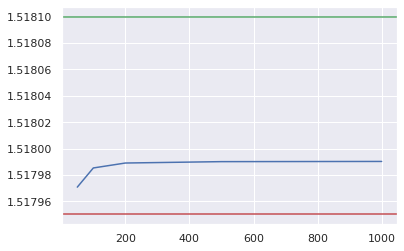

In [337]:
plt.plot(N_list, alpha_int_list_2, label="Lower bound")
plt.axhline(y = alphas[0], color = 'r', linestyle = '-')
plt.axhline(y = alphas[-1], color = 'g', linestyle = '-')

In [374]:
# Verify reasonable results
c, res, ms = lp(1000, 1.51798525)
print(min(res.x))
print(res.x[-2])
print(1/1000**(1/2))

0.03162263331617051
0.03163845628657931
0.03162277660168379


Plot of found weights vs integral weight from continuous case

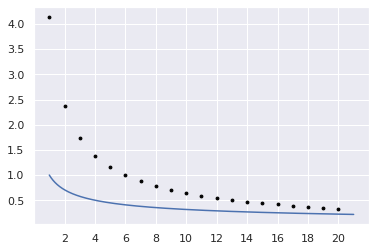

In [380]:
N = 20
alpha = 1.65
c, res, ms = lp(N, alpha)
continuous = np.linspace(1, N+1, 1000)
plt.scatter(ms, res.x, s=8, color='black')
plt.plot(continuous, continuous**(-1/2))
plt.xticks(np.arange(2, N+1, 2.0))
plt.show()

# cont = ms**alpha-


In [ ]:
N = 20
alphas = []
c, res, ms = lp(N, alpha)
continuous = np.linspace(1, N+1, 1000)
plt.scatter(ms, res.x, s=8, color='black')
plt.plot(continuous, continuous**(-1/2))
plt.xticks(np.arange(2, N+1, 2.0))
plt.show()

In [190]:
c, res, ms = lp(1, 1.5)
print(res.x)

[1.02446177]


In [37]:
print(res.x)

[7.75961067e-09 5.08741909e-09]


In [191]:
print(3 * (np.sqrt(2)/8 + np.sqrt(3)/27 + 103/1024))

1.024537988119786


# experimental

In [15]:
def lp_experimental(N, alpha, goal_fn = lambda alph: 2/alph):
    """Solves linear program specified by Schur test for the kernel $K_alpha$ truncated to N terms."""
    goal = goal_fn(alpha)

    ms = np.arange(1, N+1)
    truncated_zeta = zeta(alpha + 1) - sum(1/ms**(alpha+1))
    ubs = -ms**(alpha - 1/2) * truncated_zeta

    B = create_A(alpha, N) - np.diag(goal * np.ones(N))

    c = ms**(alpha - 1/2) 
    res = linprog(c, A_ub=B, b_ub=ubs)
    return c, res, ms


def requirement_experimental(N, alpha, brevig_bound=False, goal_fn = lambda alph: 2/alph):
    """Gives upper bound on c @ x where x is the solution to the linear program. If it is not 
     an upper bound, then the full linear program is unfeasible. """
    if brevig_bound:
        term1 = - alpha/6 * (N+1)**(alpha - 2) + (3-alpha)*(5-alpha)*(6-alpha)*(8+alpha)/(720*alpha)
        term2 = sum(n**(alpha - 1) for n in range(1, N+1))
        return term1 + term2
    else:
        ssum = zeta(alpha + 1) - sum(1/n**(alpha+1) for n in range(1, N+1))
        return (N+1)**alpha * (goal_fn(alpha)- (N+1)**(alpha) * ssum)

 
def compare_experimental(N, alphas, brevig_bound=False, goal_fn = lambda alph: 2/alph):
    """returns list of c @ x and upper bounds for each alpha. If c @ x > upper bound, then the
    full linear program is unfeasible."""
    reqs = []
    found = []
    for alpha in alphas:
        c, res, ms = lp_experimental(N, alpha, goal_fn)
        reqs.append(requirement_experimental(N, alpha, brevig_bound, goal_fn))
        found.append(c @ res.x)

    return reqs, found

def find_intersection_experimental(N, alphas, brevig_bound=False, goal_fn = lambda alph: 2/alph):
    """Finds point of intersection for requirement, c@x. The ntersection is the point where 
    the linear program starts to fail in showing C_alpha = 2/alpha"""
    reqs, found = compare_experimental(N, alphas, brevig_bound, goal_fn)

    for i in range(len(reqs)):
        if found[i] > reqs[i]:
            if i == 0:
                return None
            else:
                return alphas[i-1]
    return None


Example showcasing what the intersection is


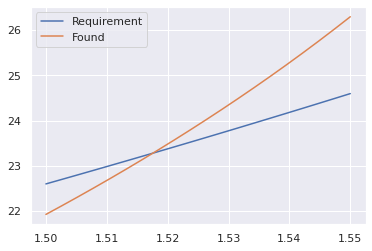

Difference between zeta requirement, Brevig requirement: 0.00021034624498739163


In [10]:
# N = 10
# alphas = np.linspace(1.5, 1.55, 20)
# reqs, found = compare_experimental(N, alphas)
# brevig_reqs, _ = compare_experimental(N, alphas, True)
# plt.plot(alphas, reqs, label="Requirement")
# # plt.plot(alphas, brevig_reqs, label="Brevig Requirement")
# plt.plot(alphas, found, label="Found")
# plt.legend()
# plt.show()
# print("Difference between zeta requirement, Brevig requirement:",
#       min([abs(x -y) for x, y in zip(reqs, brevig_reqs)]))

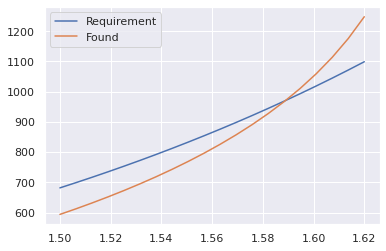

Difference between zeta requirement, Brevig requirement: 10.150448640330637


In [68]:
N = 100
alphas = np.linspace(1.5, 1.62, 20)
# eps = 1e-2#0#1e-1
reqs, found = compare_experimental(N, alphas, goal_fn = lambda alph: 2/alph + eps)
brevig_reqs, _ = compare_experimental(N, alphas, True)
plt.plot(alphas, reqs, label="Requirement")
# plt.plot(alphas, brevig_reqs, label="Brevig Requirement")
plt.plot(alphas, found, label="Found")
plt.legend()
plt.show()
print("Difference between zeta requirement, Brevig requirement:",
      min([abs(x -y) for x, y in zip(reqs, brevig_reqs)]))

In [35]:
print(2/1.512)

1.3227513227513228


In [43]:
# A = create_A(1.52, 4000)
# print(max(np.linalg.eig(A)[0]))
max_vals = []
for N in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]:
    A = create_A(1.52, N)
    max_vals.append(max(np.linalg.eig(A)[0]))


In [44]:
print(*max_vals, sep="\n")

1.0
1.101128088043762
1.1697955629661005
1.213694322496567
1.2417125382131577
1.2600886720727893
1.2725820417704465
1.2813837256516192
1.2877869872906
1.2925776183015423
1.2962492345758942
1.2991222393320574
1.3014110216760235
1.3032630319906797


In [62]:
print(2/1.52)

1.3157894736842106


In [87]:
print(max_vals[-1])

1.3032630319906797


In [53]:
diff = [max_vals[i+1] - max_vals[i] for i in range(len(max_vals)-1)]
print(*diff, sep="\n")

0.10112808804376194
0.0686674749223386
0.04389875953046651
0.02801821571659069
0.01837613385963155
0.012493369697657242
0.00880168388117264
0.006403261638980862
0.004790631010942237
0.0036716162743519742
0.0028730047561631444
0.0022887823439661226
0.001852010314656205


In [81]:
ratio = [diff[i+1] / diff[i] for i in range(len(diff)-1)]
print(*ratio, sep="\n")

0.6790148637302783
0.6392947983032002
0.6382461831784917
0.6558638153660269
0.679869323606883
0.7045083987887697
0.7275041600480386
0.7481548125065697
0.7664160036466321
0.7824904732644531
0.7966510807391624
0.809168385774483


In [54]:
mv = np.array(max_vals)
mv = mv - 2/1.52

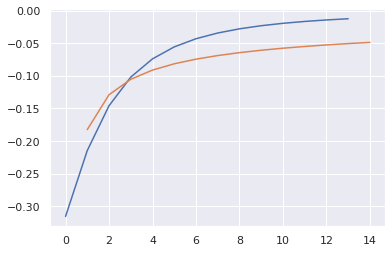

In [61]:
plt.plot(mv)
x = np.arange(1, len(mv)+1)
plt.plot(x, -1/(x*30)**(1/2))

In [78]:
alpha = 1.59
N = 4096
A = create_A(alpha, N)
max_eigenvalue = max(np.linalg.eig(A)[0])

In [79]:
print(max_eigenvalue)
print(2/alpha)

1.257059447206426
1.2578616352201257


In [84]:
# A = create_A(1.52, 4000)
# print(max(np.linalg.eig(A)[0]))
alpha_star = 1.55
max_vals_star = []
for N in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]:
    A = create_A(alpha_star, N)
    max_vals_star.append(max(np.linalg.eig(A)[0]))

In [86]:
diff_star = [max_vals_star[i+1] - max_vals_star[i] for i in range(len(max_vals_star)-1)]
ratio_star = [diff_star[i+1] / diff_star[i] for i in range(len(diff_star)-1)]
print(diff_star[-1])
print(max_vals_star[-1])
print(2/alpha_star)
print()
print(*ratio_star, sep="\n")

0.0023588305790975816
1.2797586786442419
1.2903225806451613

0.6682086323186814
0.6282852816431533
0.6271866016755426
0.6447923821378644
0.6687687887996165
0.6933446010330154
0.7162431333643515
0.7367682463448593
0.754881937872623
0.7707924212227485


In [89]:
print(1/(1 - 0.77))
print(4.35 * 0.00235)

4.347826086956522
0.010222499999999999
